In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/

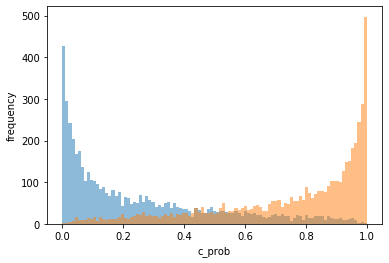

x has shape (10000, 30) 

coefficient values:
-0.4    11
 0.0    10
 0.4     4
-0.8     3
 0.8     1
 1.6     1
dtype: int64 

c has shape (10000,) 

c values
1    5031
0    4969
dtype: int64 



In [2]:
# simulate condition c as a function of covariates x

n_features = 30
n_examples = 10000

x = np.random.randn(n_examples, n_features)
xc_coeffs = .4 * np.round(np.random.randn(n_features))
c_logits = np.squeeze(x @ xc_coeffs[:, np.newaxis])

def logistic(x): return 1 / (1 + np.exp(-1 * x))

c_prob = logistic(c_logits)
c = (np.random.rand(n_examples) < c_prob).astype(int)

plt.hist(c_prob[c == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_prob[c == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

print('x has shape', np.shape(x), '\n')
print('coefficient values:')
print(pd.value_counts(xc_coeffs), '\n')
print('c has shape', np.shape(c), '\n')
print('c values')
print(pd.value_counts(c), '\n')

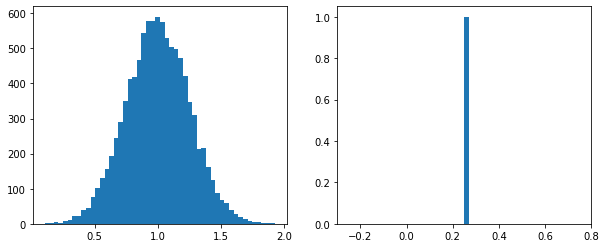

In [3]:
# simulate event times as a function of c and x with uniform censoring

max_time = 5

xmu_coeffs = .05 * np.round(np.random.randn(n_features))
mu_event = np.squeeze(1 + (x @ xmu_coeffs[:, np.newaxis]))

#xsigsq_coeffs = .02 * np.round(np.random.randn(n_features))
#sigsq_event = np.squeeze(x @ xsigsq_coeffs[:, np.newaxis])

sigsq_event = .25

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(mu_event, bins=50)
ax[1].hist(sigsq_event, bins=50)
plt.show()

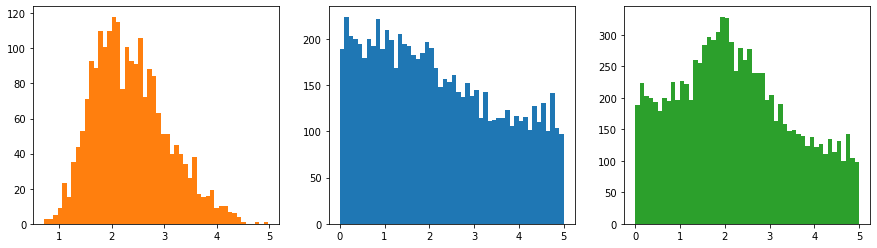

In [4]:
event_times = np.exp(mu_event + sigsq_event * np.random.randn(n_examples)) + max_time * (1 - c)
censoring_times = max_time * np.random.rand(n_examples)

t = np.minimum(event_times, censoring_times)
s = (t == event_times).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].hist(t[s == 1], color='C1', bins=50)
ax[1].hist(t[s == 0], color='C0', bins=50)
ax[2].hist(t, color='C2', bins=50)
plt.show()

In [5]:
import sys
sys.path.append('../src')
from model import CFTModel

In [6]:
mdl = CFTModel()
with tf.Session() as sess:
    mdl.train(sess, x, t[:, np.newaxis], s[:, np.newaxis], 800, learning_rate=1e-3)
    c_pred = mdl.predict_c(sess, x)
    c_weights = mdl.get_c_weights(sess)

Initial Values:
nloglik = -2.03e+09
log_p(t, s | x, c = 1): -5.39e+00
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.38e-02 t_sig: 5.00e-01

Completed Epoch 0
nloglik = -2.20e+09
log_p(t, s | x, c = 1): -5.96e+00
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -6.11e-02 t_sig: 5.00e-01

Completed Epoch 10
nloglik = -4.53e+09
log_p(t, s | x, c = 1): -1.91e+01
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -5.30e-01 t_sig: 5.00e-01

Completed Epoch 20
nloglik = -7.56e+09
log_p(t, s | x, c = 1): -5.22e+01
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -1.11e+00 t_sig: 5.00e-01

Completed Epoch 30
nloglik = -1.08e+10
log_p(t, s | x, c = 1): -1.05e+02
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -1.70e+00 t_sig: 5.00e-01

Completed Epoch 40
nloglik = -1.39e+10
log_p(t, s | x, c = 1): -1.78e+02
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.28e+00 t_sig: 5.00e-01

Completed Epoch 50
nloglik = -1.71e+10
log_p(t, s | x, c = 1): -2.71e+02
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.85e+00 t_sig: 5.00e-01

Completed Epoch 60
nlogl

Completed Epoch 580
nloglik = -1.79e+11
log_p(t, s | x, c = 1): -2.26e+04
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.44e+01 t_sig: 5.00e-01

Completed Epoch 590
nloglik = -1.82e+11
log_p(t, s | x, c = 1): -2.33e+04
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.48e+01 t_sig: 5.00e-01

Completed Epoch 600
nloglik = -1.85e+11
log_p(t, s | x, c = 1): -2.40e+04
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.51e+01 t_sig: 5.00e-01

Completed Epoch 610
nloglik = -1.88e+11
log_p(t, s | x, c = 1): -2.47e+04
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.55e+01 t_sig: 5.00e-01

Completed Epoch 620
nloglik = -1.91e+11
log_p(t, s | x, c = 1): -2.54e+04
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.58e+01 t_sig: 5.00e-01

Completed Epoch 630
nloglik = -1.94e+11
log_p(t, s | x, c = 1): -2.61e+04
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.62e+01 t_sig: 5.00e-01

Completed Epoch 640
nloglik = -1.97e+11
log_p(t, s | x, c = 1): -2.69e+04
log_p(t, s | x, c = 0): -2.21e+09
t_mu: -2.66e+01 t_sig: 5.00e-01

Completed Epo

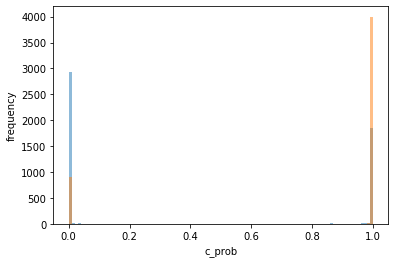

In [7]:
plt.hist(c_pred[c == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_pred[c == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

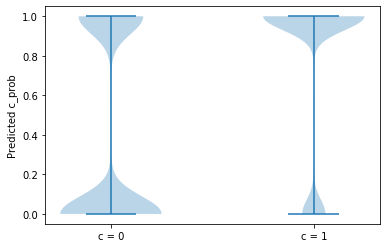

In [8]:
plt.violinplot([c_pred[c == 0], c_pred[c == 1]])
plt.xticks([1, 2], ['c = 0', 'c = 1'])
plt.ylabel('Predicted c_prob')
plt.show()

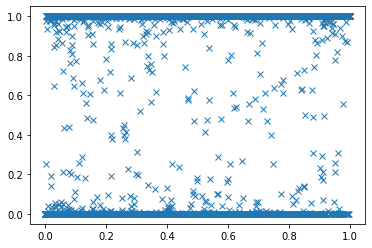

In [9]:
plt.plot(c_prob, c_pred, 'x')
plt.show()

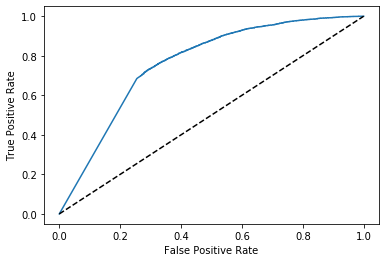

AUC = 0.76


In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(c, c_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print('AUC = %.2f' % roc_auc_score(c, c_pred))

# Issues

- nature of penalty. is there a more principled way to choose this?
- when using NN, it will predict everyone is positive (to avoid penalty, presumably)


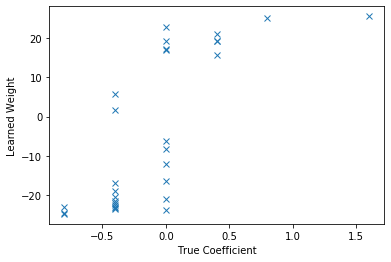

In [11]:
plt.plot(xc_coeffs, c_weights, 'x')
plt.xlabel('True Coefficient')
plt.ylabel('Learned Weight')
plt.show()